In [135]:
import pandas as pd
import numpy as np
import pickle
import re


from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [136]:
class Data:
    """
    Load the data categorize the columns to categorical and numerical
    """
    def __init__(self, filepath: str = None, targetcol: str = None):
        self.data = pd.read_csv(filepath)
        self.targetcol = targetcol

    def get_numericals(self):
        self.num_cols = list(self.data.dtypes[
            (self.data.dtypes == 'int64') | (self.data.dtypes == 'float64')| 
            (self.data.dtypes == 'int32') | (self.data.dtypes == 'float32')|
            (self.data.dtypes == 'int16') | (self.data.dtypes == 'float16')|
            (self.data.dtypes == 'int8')].keys())
        if self.targetcol in self.num_cols:
            self.num_cols.remove(self.targetcol)
        self.cat_cols = list(set(self.data.columns).difference(self.num_cols))
        if self.targetcol in self.cat_cols:
            self.cat_cols.remove(self.targetcol)
        return self.num_cols, self.cat_cols

    def get_inputs(self):
        num_cols, cat_cols = self.get_numericals()
        return num_cols, self.targetcol, self.data, cat_cols

In [137]:
def bootstrap_confidence_logistic(model, n_iterations, data):
    """
    get confidence score of the model using bootstrapping.
    args:
        targetcol: target column name
        data: whole cleaned dataframe
        num_cols: List of numerical column names
        cat_cols: List of categorical column names
        n_iterations: number of iteration to run bootstrapping
    return:
        Confidence interval: Lower and upper quantile.
    """
    try:
        scores = []
        for i in range(n_iterations):
            X_train, X_test, y_train, y_test = train_test_split(data[num_cols+cat_cols], data[targetcol], test_size=0.2,random_state=i)
            X_train = X_train.fillna(X_train.median())
            X_test = X_test.fillna(X_train.median())
            model = model.fit(X_train, y_train)
            scores.append(model.score(X_test,y_test))
        lower, upper = np.quantile(scores, q = 0.025), np.quantile(scores, q = 0.975)
        return lower, upper
    except:
        print("\n Not enough resampled data test data may have some new categories.")
        return 0,0

In [144]:
def fit_logistic_regression(X_train:pd.DataFrame=None, y_train:pd.DataFrame=None):
    """
    Train a Logistic Regression model with cross validation having many different alpha parameters.
    
    This function is not differentiable in its parameters. Hence there is no closed form of the estimator.
    
    args:
        X_train: training data dataframe
        y_train: Series of train target actual values
    return:
        ridge_model:
        alpha_: best alpha
        explanation: 2D sorted numpy array with (features, features coefficients) 
    """
    lr_clf_model = LogisticRegressionCV(cv=10, solver='liblinear', penalty="l2").fit(X_train, y_train)
    train_predictions = lr_clf_model.predict(X_train)
    train_accuracy = lr_clf_model.score(X_train,y_train)
    print("Logistic Regression Training Model Accuracy:", train_accuracy)
    print("Logistic Regression Training Model F1Score:", f1_score(y_train, train_predictions))
    feat_selected = list(X_train.columns[lr_clf_model.coef_[0].nonzero()])
    explanation = np.append(np.array(feat_selected).reshape(-1,1),
                                             lr_clf_model.coef_[0][lr_clf_model.coef_[0].nonzero()].reshape(-1,1).astype('float'),1)
    explanation[:,1] = np.abs(explanation[:,1].astype(np.float64))
    explanation = explanation[explanation[:,1].argsort()]
    return lr_clf_model, train_predictions, train_accuracy, explanation

Logistic Regression Training Model Accuracy: 0.23850398528510117
Logistic Regression Training Model F1Score: 0.0
CI:(0.21623774509803922, 0.25189950980392156)



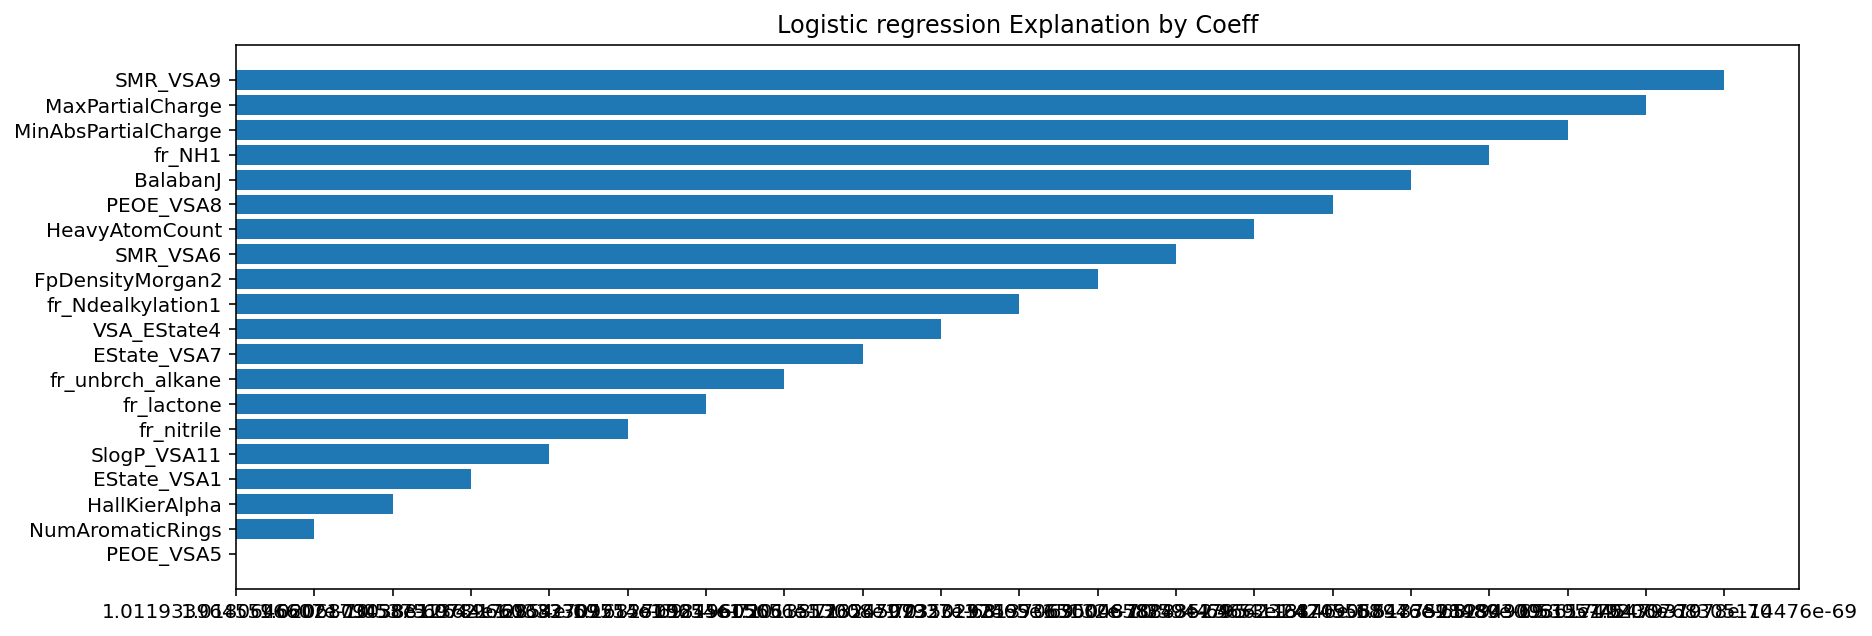

In [145]:
if __name__ == '__main__':
    data_obj = Data("/Users/lingrajsvannur/Desktop/DrugDiscovery/propertyprediction/datasets/bbb_martins.csv","property")
    num_cols, targetcol, data, cat_cols = data_obj.get_inputs()
    data = data.fillna(data.median())
    X_train, X_test, y_train, y_test = train_test_split(data[num_cols+cat_cols], data[targetcol], test_size=0.2, random_state=0)
    lr_clf_model, train_predictions, train_accuracy, explanation = fit_logistic_regression(X_train, y_train)
    lower, upper = bootstrap_confidence_logistic(lr_clf_model, 10, data)
    print(f"CI:{lower,upper}\n")
    
    
    filename = 'logistic_model.pkl'
    pickle.dump(lr_clf_model, open(filename, 'wb'))
    lr_clf_model_model = pickle.load(open(filename, 'rb'))
    
    fig, ax = plt.subplots(figsize=(14,5))
    plt.barh(explanation[:,0][:20],explanation[:,1][:20])
    plt.title('Logistic regression Explanation by Coeff')
    plt.show()

In [141]:
lr_clf_model.coef_

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [113]:
set(lr_clf_model.predict(X_train))

{0}

In [111]:
data.groupby(['property']).count()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
property,,,,,,,,,,,,,,,,,,,,,
0,479,479,479,479,479,479,479,479,479,479,...,479,479,479,479,479,479,479,479,479,479
1,1560,1560,1560,1560,1560,1560,1560,1560,1560,1560,...,1560,1560,1560,1560,1560,1560,1560,1560,1560,1560


In [124]:
lr_clf_model.predict_proba(X_train)

array([[0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       ...,
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5]])

In [126]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=0).fit(X_train, y_train)

In [128]:
model.score(X_train, y_train)

0.23850398528510117

In [131]:
pred = model.predict(X_train)

In [132]:
f1_score(y_train, pred)

0.0

{0, 1}